<a href="https://colab.research.google.com/github/LeninGF/CoursesNotes/blob/main/MarkovRL/03-blackJack-MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black Jack
- Coder: Lenin G. Falconi
## objetivos
- Explorar Muestreo de Importancia
- Explorar inicios que exploran

## Mecanica del Juego
- Dos partes, jugador y dealer
- la suma de cartes debe ser $\leq 21$
- gana el que este mas cerca de 21
- Empates: misma cantidad
- Recompensas:
    - si el jugador gana +1
    - si empata 0
    - si pierde -1
- acciones: pedir cartas / plantar

## Cartas:
- 1 a 10 vale 1 a 10
- JQK vale 10
- A vale 1 o 11 (estrategia)
- As es *util* si usa como 11. Un boolean identifica si el As vale 11
## Ejemplo:
- Cadena de estados: 2 A 3 A 9 K
- `2+11=13`
- `13+3=16`
- `16+11=27-10` # considero al inicial como 1
- `17+9 = 26-10` el otro As se vuelve 1
- `16+10 = 26`, perdi
## Programa Dealer
- Tiene una politica fija
- acciones: pedir carta mientras $\leq 17$
- se planta si $suma \geq 17$
- Cartas se reemplazan para el juego.... vuelven todas ..... no se quedan fuera algunas. Esto es para prevenir el conteo o memorizacion

- **acciones:** pedir, plantar
- **estado:**`[cartas del jugador, la carta del lider, as_util]`
- $\gamma = 1$,
- $G = \sum R$ el retorno es la suma de recompensas

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Acciones

In [33]:
ACCION_PEDIR = 0
ACCION_PLANTAR = 1
ACCIONES = [ACCION_PEDIR, ACCION_PLANTAR]

## Politica Dealer

In [34]:
POLITICA_DEALER = np.zeros(22) # cuantas sumas posibles hay
for i in range(12,17):
    POLITICA_DEALER[i] = ACCION_PEDIR
for i in range(17,22):
    POLITICA_DEALER[i] = ACCION_PLANTAR

## Politica Jugador
se usara metodos dentro y fuera de politica

hallar la politica deseada optima

In [35]:
POLITICA_JUGADOR = np.zeros(22, dtype=np.int64)
for i in range(12,20):
    POLITICA_JUGADOR[i]= ACCION_PEDIR
POLITICA_JUGADOR[20] = ACCION_PLANTAR
POLITICA_JUGADOR[21] = ACCION_PLANTAR

## Estructura de la funcion par ala politica objetivo del jugador

In [36]:
def politica_objetivo_jugador(as_util_jugador, suma_jugador, carta_dealer):
    return POLITICA_JUGADOR[suma_jugador]

## Estructura de la funcion para la politica de comportamiento del jugador
revisar distribucion binomial simula a la moneda

In [37]:
def politica_comportamiento_jugador(as_util_jugador, suma_jugador, carta_dealer):
    if np.random.binomial(1,0.5)==1:
        return ACCION_PLANTAR
    return ACCION_PEDIR

## Pedir carta

accion fija del entorno
1 al 10 , jqk


In [38]:
def pedir_carta():
    carta = np.random.randint(1,14)
    # jqk se pasan a 10
    carta = min(carta, 10)
    return carta

## Valor de la carta

In [39]:
def valor_carta(carta_id):
    return 11 if carta_id ==1 else carta_id

## Funcion Jugar

IN:

- politica de jugador
- estado inicial
- accion inicial

OUT:
- cadena de estados que ocurrieron durante el juego i.e. trayerctoria de estados

In [40]:
def jugar(politica_jugador, estado_inicial=None, accion_inicial=None):
    # estadus del jugador
    suma_jugador = 0
    trayectoria_jugador = []
    as_util_jugador = False
    # estatus del dealer
    carta1_dealer = 0
    carta2_dealer = 0
    as_util_dealer = False
    ###### inicializacion del primer estado
    # generar estado inicial si no es dado
    if estado_inicial is None:
        while suma_jugador < 12:
            carta = pedir_carta()
            suma_jugador += valor_carta(carta)
            if suma_jugador > 21:
                assert suma_jugador == 22
                suma_jugador -= 10
            else:
                as_util_jugador |= (1==carta)
        carta1_dealer = pedir_carta()
        carta2_dealer = pedir_carta()
    # empezar el juego desde un estado inicial dado
    else:
        as_util_jugador, suma_jugador, carta1_dealer = estado_inicial
        carta2_dealer = pedir_carta()
    estado = [as_util_jugador, suma_jugador, carta1_dealer]
    # Iniciar la mano del dealer
    suma_dealer = valor_carta(carta1_dealer) + valor_carta(carta2_dealer)
    as_util_dealer = 1 in (carta1_dealer, carta2_dealer)
    # comprobar si la suma pasa de 21
    if suma_dealer > 21:
        assert suma_dealer == 22
        suma_dealer -= 10
    assert suma_dealer <= 21
    assert suma_jugador <= 21
    # #################
    # empezar el juego
    while True:
        if accion_inicial is not None:
            accion = accion_inicial
            accion_inicial = None
        else:
            accion = politica_jugador(as_util_jugador, suma_jugador, carta1_dealer)
        # almacenar la trayectoria para utilizar MC y Muestreo de importancia
        trayectoria_jugador.append([(as_util_jugador, suma_jugador, carta1_dealer), accion]) # checar vid
        if accion == ACCION_PLANTAR:
            break
        carta = pedir_carta()
        # coidgo para contar el numero de As usables en la mano
        # el boolean as_utilsolo me dice si es usado como 1 o no
        contar_as = int(as_util_jugador)
        if carta == 1:
            contar_as+=1
        # Decidimos si usar nuestro As como 11 o uno
        suma_jugador += valor_carta(carta)
        while suma_jugador > 21 and contar_as:
            suma_jugador -= 10
            contar_as-=1
        # Jugador Pierde
        if suma_jugador > 21:
            return estado, -1, trayectoria_jugador
        # si no pierdo voy a turno del dealer
        assert suma_jugador <=21
        as_util_jugador = (contar_as==1)
        while True:
            accion = POLITICA_DEALER[suma_dealer]
            if accion == ACCION_PLANTAR:
                break
            otra_carta = pedir_carta()
            contar_as = int(as_util_dealer)
            if otra_carta == 1:
                contar_as +=1
            suma_dealer +=valor_carta(otra_carta)
            while suma_dealer > 21 and contar_as:
                suma_dealer -=10
                contar_as -=1
            if suma_dealer > 21:
                return estado, 1, trayectoria_jugador
            as_util_dealer = (contar_as == 1)
    # en caso de que ningunopierda comparamos parafinalizar la mano i.e. el episodio
    assert suma_jugador <= 21 and suma_dealer <=21
    if suma_jugador > suma_dealer:
        return estado, 1, trayectoria_jugador
    elif suma_jugador == suma_dealer:
        return estado, 0, trayectoria_jugador
    else:
        return estado, -1, trayectoria_jugador
    # return estado, 0, trayectoria_jugador # commentar es recomendacin de colab



Montecarlo con inicios que exploran

- porque la dimension $10\times 10\times 2\times 2$
- hace evaluacion y control
- `contar_pares_estado_accion = np.ones((10,10,2,2))` cuenta cuantas veces un estado determinado

In [41]:
def monte_carlo_es(episodios):
    valores_estado_accion = np.zeros((10,10,2,2)) # (suma_jugador, carta_deleaer, as_util, accion)
    contar_pares_estado_accion = np.ones((10,10,2,2)) # empezamos en 1, evadir division para 0
    # se actualiza montecarlo con greedy
    # politica greedy
    def politica_comportamiento(as_util, suma_jugador, carta_dealer):
        # no me agrada una funcion dentro de otra funcion. se podria escribir mejor
        as_util = int(as_util)
        suma_jugador -=12
        carta_dealer -= 1  # porque estos decrementos?
        # obtener media de los valores
        valores_ = valores_estado_accion[suma_jugador, carta_dealer, as_util, :]/\
            contar_pares_estado_accion[suma_jugador, carta_dealer, as_util, :]
        # se devuelve valor que ha dado el maximo por cado estado
        # random choice rompe empates de manera aleatoria
        return np.random.choice([accion_ for accion_, valor_ in enumerate(valores_) if valor_ == np.max(valores_)])
    # jugar una cantidad de episodios para visualizar las iteraciones
    for episodio in tqdm(range(episodios)):
        # para cada episodio empezamos con un (estado/accion) random:
        estado_inicial = [bool(np.random.choice([0,1])),
                          np.random.choice(range(12,22)),
                          np.random.choice(range(1,11))]
        accion_inicial = np.random.choice(ACCIONES)
        # se usa politica de comportamiento cuando hay episodios sino se inicia con la politica objetivo
        politica_actual = politica_comportamiento if episodio else politica_objetivo_jugador
        _, recompensa, trayectoria = jugar(politica_actual, estado_inicial, accion_inicial) # type: ignore
        check_primera_visita = set()
        for (as_util, suma_jugador, carta_dealer), accion in trayectoria:
            as_util = int(as_util)
            suma_jugador -= 12
            carta_dealer -= 1
            estado_accion = (as_util, suma_jugador, carta_dealer, accion)
            if estado_accion in check_primera_visita:
                continue
            check_primera_visita.add(estado_accion)
            # estamos con gamma = 1 por lo que no hay descuento
            valores_estado_accion[suma_jugador, carta_dealer, as_util, accion] += recompensa
            contar_pares_estado_accion[suma_jugador, carta_dealer, as_util, accion] += 1
    return valores_estado_accion / contar_pares_estado_accion


Montecarlo fuera de politica


In [42]:
def mc_fuera_politica(episodios):
    estado_inicial = [True, 13, 2] # as util, suma jugador, carta dealer
    rhos = [] # se acumula para hacer os calculos
    retornos = []

    for i in range(0, episodios):
        # _ significa estado
        _, recompensa, trayectoria_jugador = jugar(politica_comportamiento_jugador,
                                                   estado_inicial=estado_inicial) # type: ignore
        # razon de importancia
        numerador = 1.0
        denominador = 1.0
        # para cada parte de la trayectoria ejecutar el calculo de rhos
        for (as_util, suma_jugador, carta_jugador), accion in trayectoria_jugador:
            if accion == politica_objetivo_jugador(as_util, suma_jugador, carta_jugador):
                # politica objetivo jugador es determinista
                denominador *=0.5 # es 0.5 por la probabilidad que se puso 0.5 cara/sello pido/planto
            else:
                numerador = 0.0
                break
        rho = numerador/denominador
        rhos.append(rho)
        retornos.append(recompensa)
    rhos = np.asarray(rhos)
    retornos = np.asarray(retornos)
    # los retornos se han de multiplicar por los rhos para el muestreo ponderado y para elmuestreo normal
    retornos_ponderados = rhos * retornos
    rhos = np.add.accumulate(rhos)
    retornos_ponderados = np.add.accumulate(retornos_ponderados)
    # realizar elmuestro ordinario
    muestreo_ordinario = retornos_ponderados/np.arange(1,episodios+1)
    # muestreo ponderado puede tener divisiones por 0
    # uando rho sea 0 el resultado sera 0
    with np.errstate(divide='ignore', invalid='ignore'):
        muestreo_ponderado = np.where(rhos != 0, retornos_ponderados/rhos, 0)
    return muestreo_ordinario, muestreo_ponderado

## Funciones para graficar


In [43]:
def pol_val_mc_es():
    # montecarlo politica inicios que exploran valores de estado
    valores_estado_accion = monte_carlo_es(50000)
    # dos poiliticas 1. as util y 0. no as util
    # valores accion estado optimos
    valores_estado_no_as_util = np.max(valores_estado_accion[:,:,0,:], axis=-1)
    valores_estado_si_as_util = np.max(valores_estado_accion[:,:,1,:], axis=-1)
    # politica optima
    # opengo la accion que me dio el mejor valor
    accion_no_as_util = np.argmax(valores_estado_accion[:,:,0,:],axis=-1)
    accion_si_as_util = np.argmax(valores_estado_accion[:,:,1,:],axis=-1)
    # Para graficar
    imagenes = [accion_si_as_util,
                valores_estado_si_as_util,
                accion_no_as_util,
                valores_estado_no_as_util]
    titulos = ["Politica optima con AS util",
               "valores optimos con AS Util",
               "POlitica Optima sin As Util",
               "valores Optimos sin As Util"]
    _, axes = plt.subplots(2,2,figsize=(40,30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for imagen, titulo, axis in zip(imagenes, titulos, axes):
        fig = sns.heatmap(np.flipud(imagen),
                          cmap="YlGnBu",
                          ax=axis,
                          xticklabels=range(1,11), # type: ignore
                          yticklabels=list(reversed(range(12,22)))) # type: ignore
        fig.set_ylabel('Suma del Jugador', fontsize=30)
        fig.set_xlabel('Mano del Dealer', fontsize=30)
        fig.set_title(titulo, fontsize=30)
    plt.show()
    plt.close()

Grafica del muestreo ordinario vs el ponderado

In [44]:
def muestreo_ordinario_ponderado():
    valor_optimo = -0.277726  # este valor dedonde?
    episodios = 10000
    repeticiones = 100
    error_ordinario = np.zeros(episodios)
    error_ponderado = np.zeros(episodios)
    for i in tqdm(range(0, repeticiones)):
        muestreo_ordinario_, muestreo_ponderado_ = mc_fuera_politica(episodios=episodios)
        error_ordinario += np.power(muestreo_ordinario_ - valor_optimo,2)
        error_ponderado += np.power(muestreo_ponderado_ - valor_optimo,2)
    error_ordinario /= repeticiones
    error_ponderado /= repeticiones
    plt.plot(np.arange(1,episodios+1), error_ordinario, color='green', label='Muestreo de Importancia Ordinario')
    plt.plot(np.arange(1,episodios+1), error_ponderado, color='red', label='Muestreo de Importancia Ponderado')
    plt.ylim(-0.1,5)
    plt.xlabel('Episodios (escala logaritmica)')
    plt.ylabel(f'Error cuadratico promedio\n(promedio de {repeticiones} repeticiones)')
    plt.xscale('log')
    plt.legend()
    plt.show()
    plt.close()



## Ejecucion

100%|██████████| 50000/50000 [00:05<00:00, 8851.09it/s]


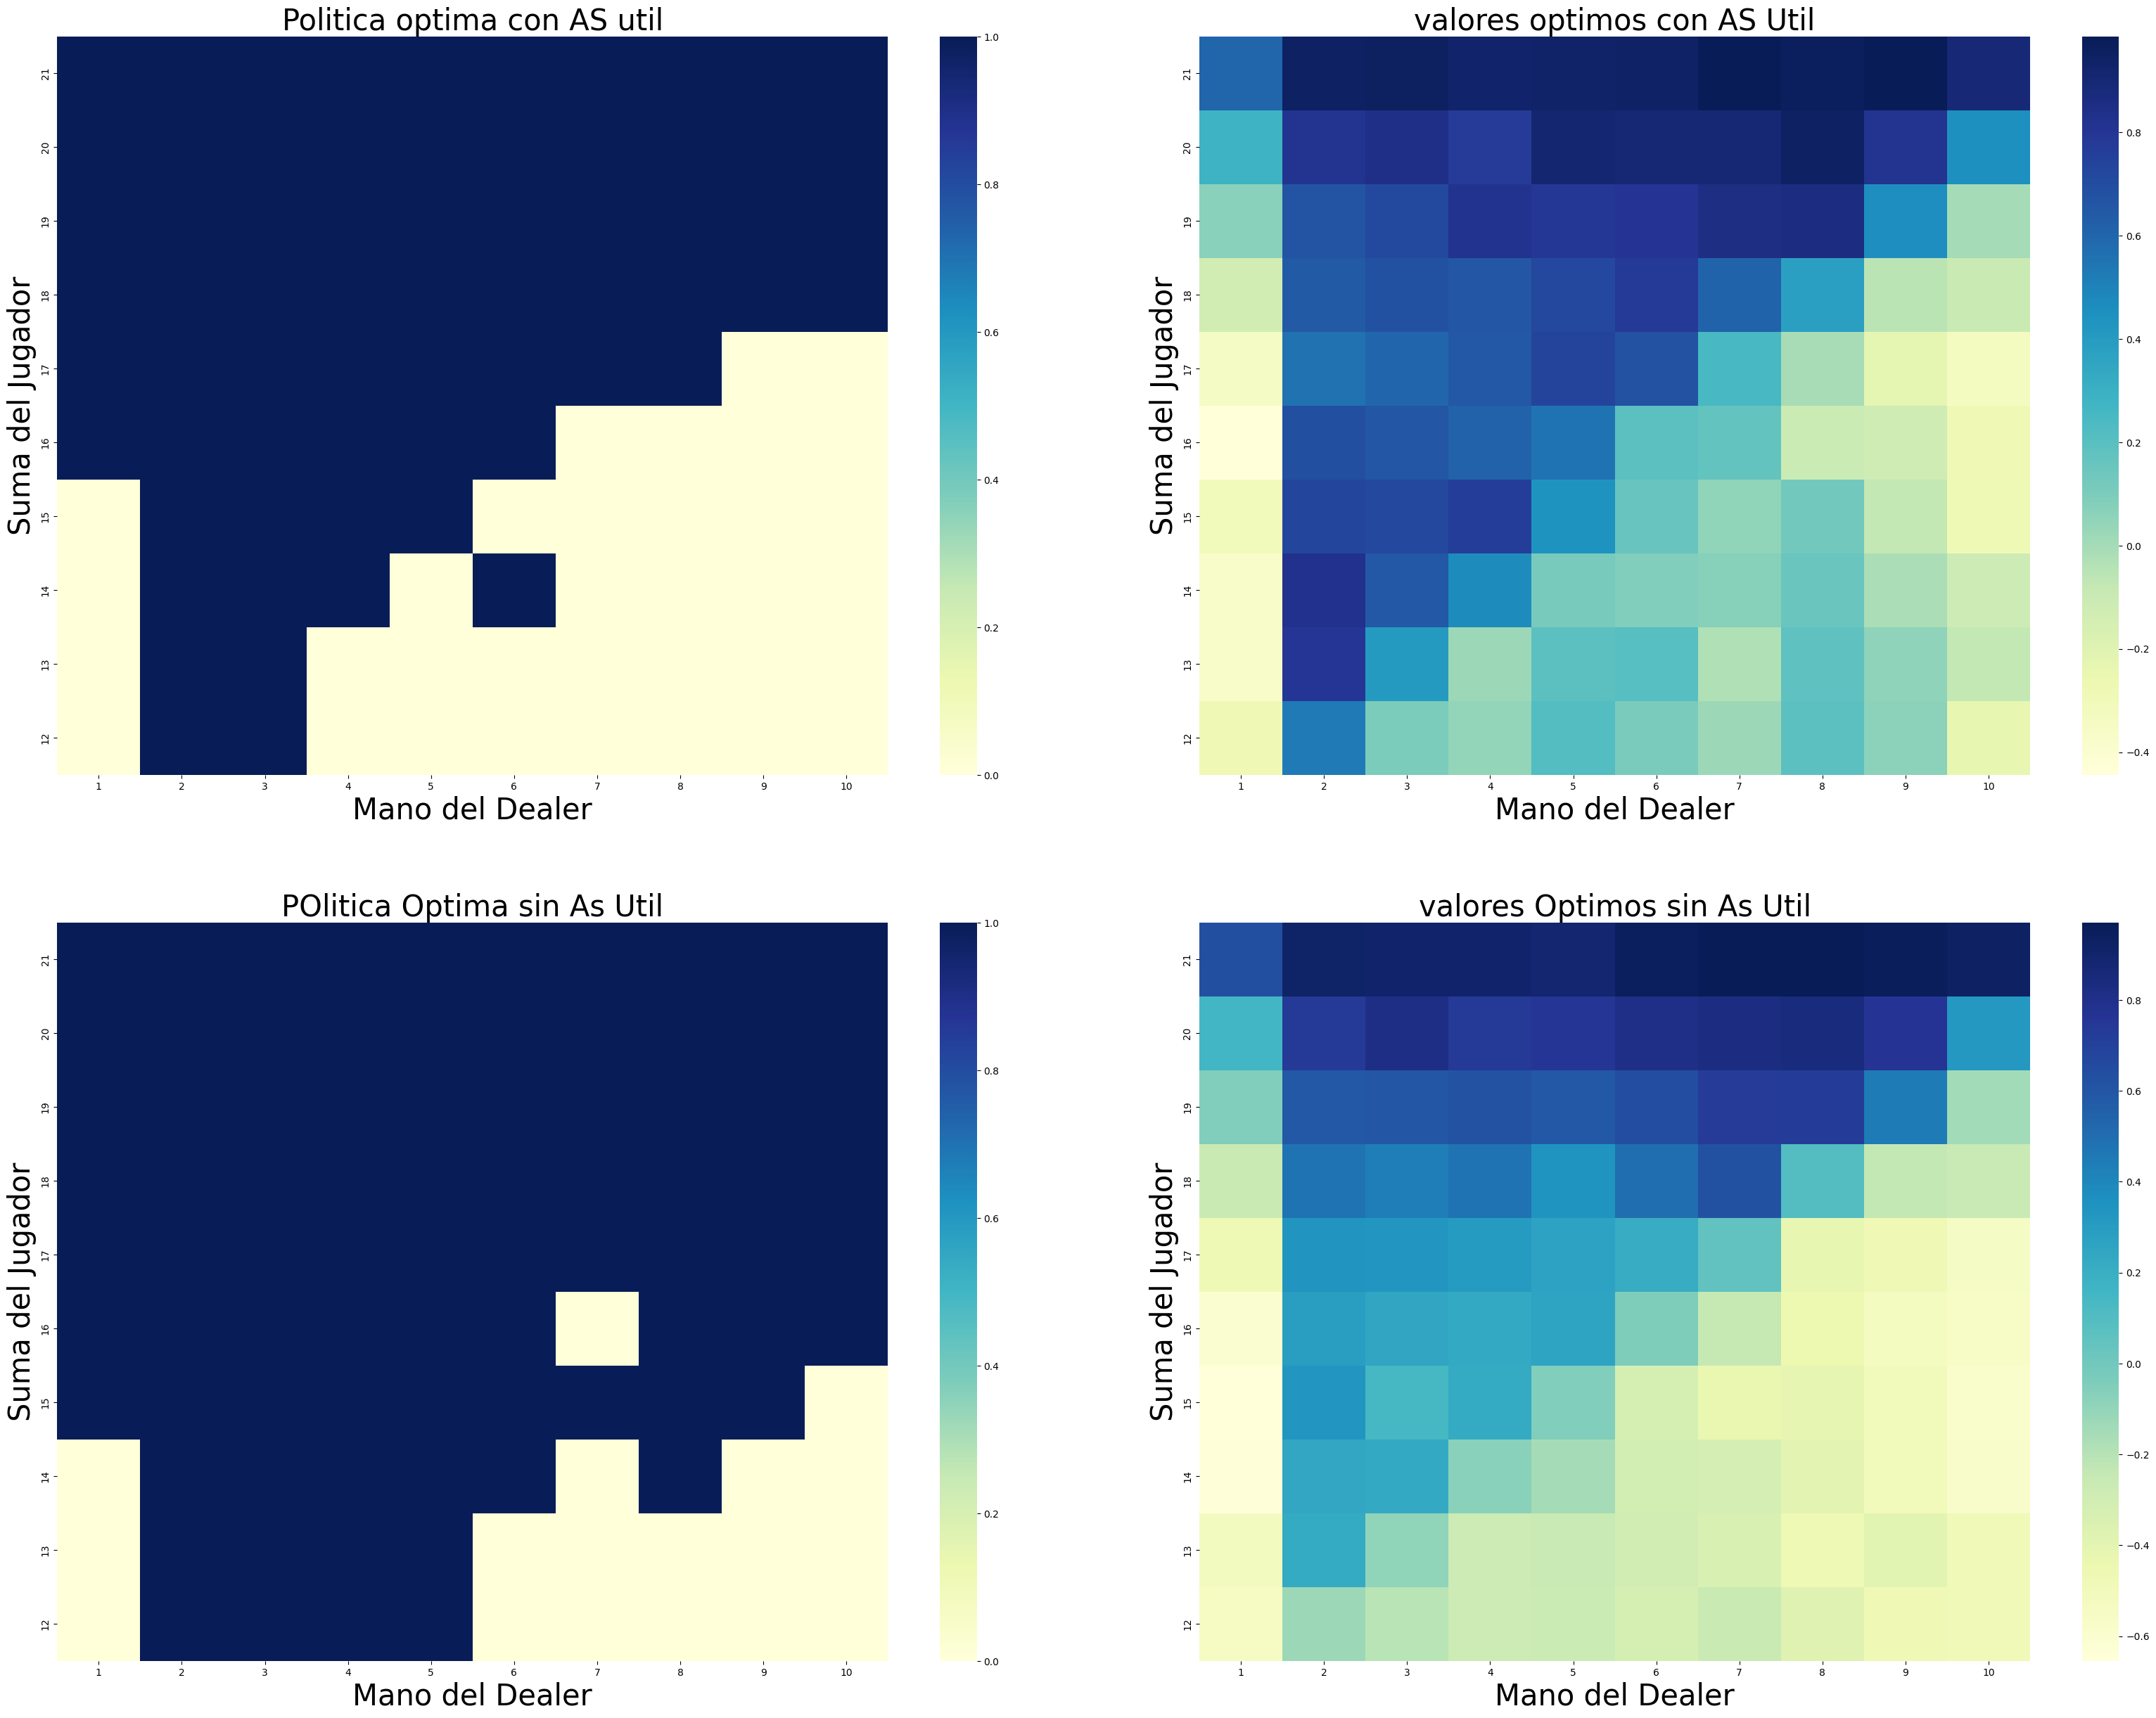

100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


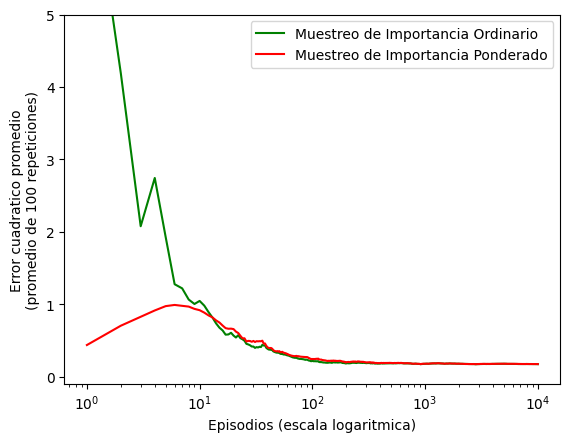

In [45]:
pol_val_mc_es()
muestreo_ordinario_ponderado()